In [1]:
# 기본적인 부분
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc("font", family="Nanum Gothic")
plt.rcParams["axes.unicode_minus"]=False

# 데이터 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# 학습 알고리즘
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet

from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report
from scipy.special import expit, softmax

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

from sklearn.ensemble import RandomForestClassifier

# 서울시 요식업 매출 예측

## 데이터 불러오기 및 결합

### 서울시 상권 추정매출  

In [2]:
seoul_sales=pd.read_csv("../data/서울시 상권분석서비스(추정매출-상권).csv", encoding="cp949")
seoul_sales.shape

(87179, 55)

In [3]:
seoul_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87179 entries, 0 to 87178
Data columns (total 55 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   기준_년분기_코드        87179 non-null  int64  
 1   상권_구분_코드         87179 non-null  object 
 2   상권_구분_코드_명       87179 non-null  object 
 3   상권_코드            87179 non-null  int64  
 4   상권_코드_명          87179 non-null  object 
 5   서비스_업종_코드        87179 non-null  object 
 6   서비스_업종_코드_명      87179 non-null  object 
 7   당월_매출_금액         87179 non-null  float64
 8   당월_매출_건수         87179 non-null  int64  
 9   주중_매출_금액         87179 non-null  float64
 10  주말_매출_금액         87179 non-null  float64
 11  월요일_매출_금액        87179 non-null  float64
 12  화요일_매출_금액        87179 non-null  float64
 13  수요일_매출_금액        87179 non-null  float64
 14  목요일_매출_금액        87179 non-null  float64
 15  금요일_매출_금액        87179 non-null  float64
 16  토요일_매출_금액        87179 non-null  float64
 17  일요일_매출_금액   

In [4]:
seoul_sales

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,...,시간대_건수~21_매출_건수,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수
0,20241,U,관광특구,3001491,이태원 관광특구,CS100001,한식음식점,1.185751e+10,254192,6.640829e+09,...,69016,38472,129419,109336,1277,73116,86124,33511,28074,16652
1,20241,U,관광특구,3001491,이태원 관광특구,CS100002,중식음식점,1.911647e+09,46140,1.259317e+09,...,18085,4918,21479,21646,151,14443,15206,5918,4892,2514
2,20241,U,관광특구,3001491,이태원 관광특구,CS100003,일식음식점,7.273213e+08,10811,4.611840e+08,...,3596,2734,4855,4682,52,2911,3636,1345,1222,371
3,20241,U,관광특구,3001491,이태원 관광특구,CS100004,양식음식점,1.673468e+10,414722,8.256458e+09,...,135195,83964,228805,173511,3268,151680,156120,45901,31260,14074
4,20241,U,관광특구,3001491,이태원 관광특구,CS100005,제과점,1.255782e+09,96224,7.704259e+08,...,28562,8063,38105,54368,660,29740,28886,12736,12976,7472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87174,20244,R,전통시장,3130326,고덕 골목형상점가,CS300011,일반의류,3.159036e+08,5900,2.440665e+08,...,1557,137,1416,4484,0,88,715,1339,1411,2347
87175,20244,R,전통시장,3130326,고덕 골목형상점가,CS300018,의약품,2.702032e+09,199951,2.241545e+09,...,44059,251,94886,105065,757,8985,35741,52590,38859,63019
87176,20244,R,전통시장,3130327,"평화시장(남평화시장, 제일평화시장, 신평화패션타운)",CS300001,슈퍼마켓,2.757434e+08,34621,2.391642e+08,...,4204,6439,24508,9052,76,3182,9129,6136,7311,7727
87177,20244,R,전통시장,3130327,"평화시장(남평화시장, 제일평화시장, 신평화패션타운)",CS300011,일반의류,1.790034e+10,88634,1.524540e+10,...,8415,4073,27011,58366,543,2308,8551,7600,15202,51171


In [5]:
seoul_sales_copy=seoul_sales.copy()

In [6]:
seoul_restaurant_sales = seoul_sales_copy[seoul_sales_copy["서비스_업종_코드"].str.startswith("CS1")]  # 요식업
seoul_restaurant_sales.head()

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,...,시간대_건수~21_매출_건수,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수
0,20241,U,관광특구,3001491,이태원 관광특구,CS100001,한식음식점,1.185751e+10,254192,6.640829e+09,...,69016,38472,129419,109336,1277,73116,86124,33511,28074,16652
1,20241,U,관광특구,3001491,이태원 관광특구,CS100002,중식음식점,1.911647e+09,46140,1.259317e+09,...,18085,4918,21479,21646,151,14443,15206,5918,4892,2514
2,20241,U,관광특구,3001491,이태원 관광특구,CS100003,일식음식점,7.273213e+08,10811,4.611840e+08,...,3596,2734,4855,4682,52,2911,3636,1345,1222,371
3,20241,U,관광특구,3001491,이태원 관광특구,CS100004,양식음식점,1.673468e+10,414722,8.256458e+09,...,135195,83964,228805,173511,3268,151680,156120,45901,31260,14074
4,20241,U,관광특구,3001491,이태원 관광특구,CS100005,제과점,1.255782e+09,96224,7.704259e+08,...,28562,8063,38105,54368,660,29740,28886,12736,12976,7472


### 서울시 상권 유동인구

In [7]:
seoul_street_people=pd.read_csv("../data/서울시 상권분석서비스(길단위인구-상권).csv", encoding="cp949")
seoul_street_people.shape

(6595, 27)

In [8]:
seoul_street_people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6595 entries, 0 to 6594
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   기준_년분기_코드         6595 non-null   int64 
 1   상권_구분_코드          6595 non-null   object
 2   상권_구분_코드_명        6595 non-null   object
 3   상권_코드             6595 non-null   int64 
 4   상권_코드_명           6595 non-null   object
 5   총_유동인구_수          6595 non-null   int64 
 6   남성_유동인구_수         6595 non-null   int64 
 7   여성_유동인구_수         6595 non-null   int64 
 8   연령대_10_유동인구_수     6595 non-null   int64 
 9   연령대_20_유동인구_수     6595 non-null   int64 
 10  연령대_30_유동인구_수     6595 non-null   int64 
 11  연령대_40_유동인구_수     6595 non-null   int64 
 12  연령대_50_유동인구_수     6595 non-null   int64 
 13  연령대_60_이상_유동인구_수  6595 non-null   int64 
 14  시간대_00_06_유동인구_수  6595 non-null   int64 
 15  시간대_06_11_유동인구_수  6595 non-null   int64 
 16  시간대_11_14_유동인구_수  6595 non-null   int64 
 17  시간대_14_17_유동인구

In [9]:
seoul_street_people.head()

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,...,시간대_14_17_유동인구_수,시간대_17_21_유동인구_수,시간대_21_24_유동인구_수,월요일_유동인구_수,화요일_유동인구_수,수요일_유동인구_수,목요일_유동인구_수,금요일_유동인구_수,토요일_유동인구_수,일요일_유동인구_수
0,20241,U,관광특구,3001491,이태원 관광특구,2155176,1100997,1054179,140314,532219,...,320185,435781,276720,284230,272781,286789,286045,318414,368486,338431
1,20241,U,관광특구,3001492,명동 남대문 북창동 다동 무교동 관광특구,6889856,3343470,3546388,335824,1194547,...,1706632,1327800,343472,1040403,1133875,1202348,1130314,1103850,706014,573054
2,20241,U,관광특구,3001493,동대문패션타운 관광특구,3384560,1595828,1788732,188119,645950,...,524693,620807,401942,504854,524755,553766,540100,497858,381895,381333
3,20241,U,관광특구,3001494,종로?청계 관광특구,8440796,4496772,3944023,358062,1523184,...,1808704,1691285,660774,1258576,1328555,1410371,1345939,1334099,998247,765010
4,20241,U,관광특구,3001495,잠실 관광특구,4110178,1976808,2133370,434196,915211,...,653233,879474,477929,570999,570194,589977,580551,598178,621983,578294


### 서울시 상권 직장인구

In [10]:
seoul_working_people=pd.read_csv("../data/서울시 상권분석서비스(직장인구-상권).csv", encoding="cp949")
seoul_working_people.shape

(6549, 26)

In [11]:
seoul_working_people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6549 entries, 0 to 6548
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   기준_년분기_코드            6549 non-null   int64 
 1   상권_구분_코드             6549 non-null   object
 2   상권_구분_코드_명           6549 non-null   object
 3   상권_코드                6549 non-null   int64 
 4   상권_코드_명              6549 non-null   object
 5   총_직장_인구_수            6549 non-null   int64 
 6   남성_직장_인구_수           6549 non-null   int64 
 7   여성_직장_인구_수           6549 non-null   int64 
 8   연령대_10_직장_인구_수       6549 non-null   int64 
 9   연령대_20_직장_인구_수       6549 non-null   int64 
 10  연령대_30_직장_인구_수       6549 non-null   int64 
 11  연령대_40_직장_인구_수       6549 non-null   int64 
 12  연령대_50_직장_인구_수       6549 non-null   int64 
 13  연령대_60_이상_직장_인구_수    6549 non-null   int64 
 14  남성연령대_10_직장_인구_수     6549 non-null   int64 
 15  남성연령대_20_직장_인구_수     6549 non-null   int64 
 16  남성연령대_

In [12]:
seoul_working_people.head()

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수,연령대_10_직장_인구_수,연령대_20_직장_인구_수,...,남성연령대_30_직장_인구_수,남성연령대_40_직장_인구_수,남성연령대_50_직장_인구_수,남성연령대_60_이상_직장_인구_수,여성연령대_10_직장_인구_수,여성연령대_20_직장_인구_수,여성연령대_30_직장_인구_수,여성연령대_40_직장_인구_수,여성연령대_50_직장_인구_수,여성연령대_60_이상_직장_인구_수
0,20241,U,관광특구,3001491,이태원 관광특구,28395,15935,12460,8,6830,...,4986,4313,3583,842,0,4627,4869,2052,722,190
1,20241,U,관광특구,3001492,명동 남대문 북창동 다동 무교동 관광특구,214604,123445,91159,396,43270,...,38123,36717,25448,6374,309,26574,33802,18817,8660,2997
2,20241,U,관광특구,3001493,동대문패션타운 관광특구,33474,16833,16641,273,9661,...,4972,3883,2050,1183,164,5025,3641,2930,3328,1553
3,20241,U,관광특구,3001494,종로?청계 관광특구,47296,26388,20908,670,9566,...,7326,7672,5302,1732,428,5452,6816,5204,2256,752
4,20241,U,관광특구,3001495,잠실 관광특구,111557,65817,45740,195,18343,...,18331,18070,13050,7197,115,9254,10943,10338,11338,3752


### 데이터 병합
> 서울시 추정매출: 서비스 업종 별로 나누기 -> 상권별로 서비스 업종의 매출관련 정보  
> 서울시 유동인구 및 직장인구: 상권별로 인구관련 정보  

In [13]:
seoul_restaurant_sales["서비스_업종_코드_명"].unique()

array(['한식음식점', '중식음식점', '일식음식점', '양식음식점', '제과점', '패스트푸드점', '치킨전문점',
       '분식전문점', '호프-간이주점', '커피-음료'], dtype=object)

In [14]:
seoul_restaurant_list = seoul_restaurant_sales["서비스_업종_코드_명"].unique()

results_with_working_population = {}

for restaurant in seoul_restaurant_list:
    temp_df = seoul_restaurant_sales[seoul_restaurant_sales["서비스_업종_코드_명"] == restaurant]
    
    # 평균매출
    mean_sales = temp_df.groupby(["상권_코드_명", "기준_년분기_코드"])[["당월_매출_금액", "월요일_매출_금액", "화요일_매출_금액", "수요일_매출_금액",
                                                            "목요일_매출_금액", "금요일_매출_금액", "토요일_매출_금액", "일요일_매출_금액"]].mean().reset_index()
    mean_sales.rename(columns={"당월_매출_금액": "평균매출"}, inplace=True)
    
    # 유동인구 데이터와 병합
    merged = pd.merge(mean_sales, seoul_street_people, on=["상권_코드_명", "기준_년분기_코드"], how="left")
    # 직장인구 데이터와 병합
    merged_with_working = pd.merge(merged, seoul_working_people, on=["상권_코드_명", "기준_년분기_코드"], how="left")
    
    # 음식점별로 묶기 (한식음식점 데이터프레임, 중식음식점 데이터프레임, ... )
    results_with_working_population[restaurant] = merged_with_working

In [15]:
results_with_working_population

{'한식음식점':            상권_코드_명  기준_년분기_코드          평균매출    월요일_매출_금액    화요일_매출_금액  \
 0     4.19민주묘지역 2번      20241  1.511042e+09  192138649.0  163369581.0   
 1     4.19민주묘지역 2번      20242  2.357278e+09  224191430.0  315353738.0   
 2     4.19민주묘지역 2번      20243  2.139687e+09  182454874.0  259612551.0   
 3     4.19민주묘지역 2번      20244  1.677641e+09  147597974.0  264130427.0   
 4             63빌딩      20241  4.421640e+09  607478861.0  700391106.0   
 ...            ...        ...           ...          ...          ...   
 5640          흑리단길      20244  1.273518e+09  157868110.0  190648180.0   
 5641          흑석시장      20241  2.768305e+08   40129023.0   44075401.0   
 5642          흑석시장      20242  4.008547e+08   76671085.0   65778859.0   
 5643          흑석시장      20243  3.245011e+08   51801697.0   47844328.0   
 5644          흑석시장      20244  3.613522e+08   56326228.0   56115901.0   
 
         수요일_매출_금액    목요일_매출_금액    금요일_매출_금액    토요일_매출_금액    일요일_매출_금액  ...  \
 0     204569944.0  14

In [16]:
keys=results_with_working_population.keys()
keys

dict_keys(['한식음식점', '중식음식점', '일식음식점', '양식음식점', '제과점', '패스트푸드점', '치킨전문점', '분식전문점', '호프-간이주점', '커피-음료'])

In [17]:
values=results_with_working_population.values()
values

dict_values([           상권_코드_명  기준_년분기_코드          평균매출    월요일_매출_금액    화요일_매출_금액  \
0     4.19민주묘지역 2번      20241  1.511042e+09  192138649.0  163369581.0   
1     4.19민주묘지역 2번      20242  2.357278e+09  224191430.0  315353738.0   
2     4.19민주묘지역 2번      20243  2.139687e+09  182454874.0  259612551.0   
3     4.19민주묘지역 2번      20244  1.677641e+09  147597974.0  264130427.0   
4             63빌딩      20241  4.421640e+09  607478861.0  700391106.0   
...            ...        ...           ...          ...          ...   
5640          흑리단길      20244  1.273518e+09  157868110.0  190648180.0   
5641          흑석시장      20241  2.768305e+08   40129023.0   44075401.0   
5642          흑석시장      20242  4.008547e+08   76671085.0   65778859.0   
5643          흑석시장      20243  3.245011e+08   51801697.0   47844328.0   
5644          흑석시장      20244  3.613522e+08   56326228.0   56115901.0   

        수요일_매출_금액    목요일_매출_금액    금요일_매출_금액    토요일_매출_금액    일요일_매출_금액  ...  \
0     204569944.0  144432248.0  

In [18]:
items=results_with_working_population.items()
items

dict_items([('한식음식점',            상권_코드_명  기준_년분기_코드          평균매출    월요일_매출_금액    화요일_매출_금액  \
0     4.19민주묘지역 2번      20241  1.511042e+09  192138649.0  163369581.0   
1     4.19민주묘지역 2번      20242  2.357278e+09  224191430.0  315353738.0   
2     4.19민주묘지역 2번      20243  2.139687e+09  182454874.0  259612551.0   
3     4.19민주묘지역 2번      20244  1.677641e+09  147597974.0  264130427.0   
4             63빌딩      20241  4.421640e+09  607478861.0  700391106.0   
...            ...        ...           ...          ...          ...   
5640          흑리단길      20244  1.273518e+09  157868110.0  190648180.0   
5641          흑석시장      20241  2.768305e+08   40129023.0   44075401.0   
5642          흑석시장      20242  4.008547e+08   76671085.0   65778859.0   
5643          흑석시장      20243  3.245011e+08   51801697.0   47844328.0   
5644          흑석시장      20244  3.613522e+08   56326228.0   56115901.0   

        수요일_매출_금액    목요일_매출_금액    금요일_매출_금액    토요일_매출_금액    일요일_매출_금액  ...  \
0     204569944.0  1444

In [19]:
# 음식점 이름을 인덱스로 설정
for restaurant, df in results_with_working_population.items():
    df["음식점"] = restaurant

seoul_restaurants = pd.concat(results_with_working_population.values(), ignore_index=True)
seoul_restaurants

,상권_코드_명,기준_년분기_코드,평균매출,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,일요일_매출_금액,...,남성연령대_40_직장_인구_수,남성연령대_50_직장_인구_수,남성연령대_60_이상_직장_인구_수,여성연령대_10_직장_인구_수,여성연령대_20_직장_인구_수,여성연령대_30_직장_인구_수,여성연령대_40_직장_인구_수,여성연령대_50_직장_인구_수,여성연령대_60_이상_직장_인구_수,음식점
0,4.19민주묘지역 2번,20241,1.511042e+09,192138649.0,163369581.0,204569944.0,144432248.0,218339674.0,310092624.0,278098826.0,...,12.0,30.0,61.0,0.0,4.0,4.0,9.0,12.0,28.0,한식음식점
1,4.19민주묘지역 2번,20242,2.357278e+09,224191430.0,315353738.0,333415209.0,225185951.0,329648497.0,433541194.0,495941637.0,...,12.0,30.0,61.0,0.0,4.0,4.0,9.0,12.0,28.0,한식음식점
2,4.19민주묘지역 2번,20243,2.139687e+09,182454874.0,259612551.0,301586307.0,201482814.0,293899974.0,396579369.0,504070794.0,...,12.0,30.0,61.0,0.0,4.0,4.0,9.0,12.0,28.0,한식음식점
3,4.19민주묘지역 2번,20244,1.677641e+09,147597974.0,264130427.0,263440973.0,138688349.0,199392854.0,340384876.0,324005249.0,...,17.0,44.0,89.0,0.0,5.0,6.0,14.0,16.0,43.0,한식음식점
4,63빌딩,20241,4.421640e+09,607478861.0,700391106.0,717229677.0,727164739.0,644220960.0,593638759.0,431516392.0,...,1592.0,979.0,244.0,12.0,660.0,819.0,470.0,251.0,116.0,한식음식점
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27090,휘문고교사거리,20244,3.145092e+08,47854498.0,46181689.0,44122618.0,48577748.0,47842588.0,20108099.0,59821969.0,...,2064.0,1357.0,827.0,45.0,1363.0,1488.0,1147.0,1271.0,825.0,커피-음료
27091,흑리단길,20241,2.867859e+08,37330932.0,41645901.0,47787694.0,42169259.0,49918190.0,38330297.0,29603618.0,...,3.0,2.0,2.0,0.0,0.0,2.0,2.0,2.0,0.0,커피-음료
27092,흑리단길,20242,3.453173e+08,44044468.0,55036446.0,48656057.0,47865545.0,49277626.0,57065823.0,43371329.0,...,3.0,2.0,2.0,0.0,0.0,2.0,2.0,2.0,0.0,커피-음료
27093,흑리단길,20243,3.433911e+08,44236477.0,44587863.0,51124383.0,48861132.0,55330373.0,54887089.0,44363814.0,...,3.0,2.0,2.0,0.0,0.0,2.0,2.0,2.0,0.0,커피-음료


### 1차 컬럼 정리

In [20]:
seoul_restaurants.columns

Index(['상권_코드_명', '기준_년분기_코드', '평균매출', '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액',
       '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액', '상권_구분_코드_x',
       '상권_구분_코드_명_x', '상권_코드_x', '총_유동인구_수', '남성_유동인구_수', '여성_유동인구_수',
       '연령대_10_유동인구_수', '연령대_20_유동인구_수', '연령대_30_유동인구_수', '연령대_40_유동인구_수',
       '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수', '시간대_00_06_유동인구_수',
       '시간대_06_11_유동인구_수', '시간대_11_14_유동인구_수', '시간대_14_17_유동인구_수',
       '시간대_17_21_유동인구_수', '시간대_21_24_유동인구_수', '월요일_유동인구_수', '화요일_유동인구_수',
       '수요일_유동인구_수', '목요일_유동인구_수', '금요일_유동인구_수', '토요일_유동인구_수', '일요일_유동인구_수',
       '상권_구분_코드_y', '상권_구분_코드_명_y', '상권_코드_y', '총_직장_인구_수', '남성_직장_인구_수',
       '여성_직장_인구_수', '연령대_10_직장_인구_수', '연령대_20_직장_인구_수', '연령대_30_직장_인구_수',
       '연령대_40_직장_인구_수', '연령대_50_직장_인구_수', '연령대_60_이상_직장_인구_수',
       '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수', '남성연령대_30_직장_인구_수',
       '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수', '남성연령대_60_이상_직장_인구_수',
       '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수', '여성연령대_30_직장_인구_수',
 

In [21]:
seoul_restaurants["초년_유동인구_수"] = (seoul_restaurants["연령대_10_유동인구_수"] + seoul_restaurants["연령대_20_유동인구_수"])
seoul_restaurants["중년_유동인구_수"] = (seoul_restaurants["연령대_30_유동인구_수"] + seoul_restaurants["연령대_40_유동인구_수"])
seoul_restaurants["노년_유동인구_수"] = (seoul_restaurants["연령대_50_유동인구_수"] + seoul_restaurants["연령대_60_이상_유동인구_수"])

seoul_restaurants["초년_직장_인구_수"] = (seoul_restaurants["연령대_10_직장_인구_수"] + seoul_restaurants["연령대_20_직장_인구_수"])
seoul_restaurants["중년_직장_인구_수"] = (seoul_restaurants["연령대_30_직장_인구_수"] + seoul_restaurants["연령대_40_직장_인구_수"])
seoul_restaurants["노년_직장_인구_수"] = (seoul_restaurants["연령대_50_직장_인구_수"] + seoul_restaurants["연령대_60_이상_직장_인구_수"])

columns_to_drop=["상권_구분_코드_y", "상권_구분_코드_명_y", "상권_코드_y", 
                 "상권_구분_코드_x", "상권_코드_x", 
                 "월요일_유동인구_수", "화요일_유동인구_수", "수요일_유동인구_수", "목요일_유동인구_수", 
                 "금요일_유동인구_수", "토요일_유동인구_수", "일요일_유동인구_수", 
                 "연령대_10_유동인구_수", "연령대_20_유동인구_수", "연령대_30_유동인구_수", 
                 "연령대_40_유동인구_수", "연령대_50_유동인구_수", "연령대_60_이상_유동인구_수", 
                 "연령대_10_직장_인구_수", "연령대_20_직장_인구_수", "연령대_30_직장_인구_수", 
                 "연령대_40_직장_인구_수", "연령대_50_직장_인구_수", "연령대_60_이상_직장_인구_수", 
                 "시간대_00_06_유동인구_수", "시간대_06_11_유동인구_수", "시간대_11_14_유동인구_수", 
                 "시간대_14_17_유동인구_수", "시간대_17_21_유동인구_수", "시간대_21_24_유동인구_수", 
                 "남성연령대_10_직장_인구_수", "남성연령대_20_직장_인구_수", "남성연령대_30_직장_인구_수", 
                 "남성연령대_40_직장_인구_수", "남성연령대_50_직장_인구_수", "남성연령대_60_이상_직장_인구_수", 
                 "여성연령대_10_직장_인구_수", "여성연령대_20_직장_인구_수", "여성연령대_30_직장_인구_수", 
                 "여성연령대_40_직장_인구_수", "여성연령대_50_직장_인구_수", "여성연령대_60_이상_직장_인구_수"]

seoul_restaurants_drop = seoul_restaurants.drop(columns=columns_to_drop)
seoul_restaurants_drop.columns = seoul_restaurants_drop.columns.str.replace("_x", "")
seoul_restaurants_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27095 entries, 0 to 27094
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   상권_코드_명     27095 non-null  object 
 1   기준_년분기_코드   27095 non-null  int64  
 2   평균매출        27095 non-null  float64
 3   월요일_매출_금액   27095 non-null  float64
 4   화요일_매출_금액   27095 non-null  float64
 5   수요일_매출_금액   27095 non-null  float64
 6   목요일_매출_금액   27095 non-null  float64
 7   금요일_매출_금액   27095 non-null  float64
 8   토요일_매출_금액   27095 non-null  float64
 9   일요일_매출_금액   27095 non-null  float64
 10  상권_구분_코드_명  27084 non-null  object 
 11  총_유동인구_수    27084 non-null  float64
 12  남성_유동인구_수   27084 non-null  float64
 13  여성_유동인구_수   27084 non-null  float64
 14  총_직장_인구_수   27017 non-null  float64
 15  남성_직장_인구_수  27017 non-null  float64
 16  여성_직장_인구_수  27017 non-null  float64
 17  음식점         27095 non-null  object 
 18  초년_유동인구_수   27084 non-null  float64
 19  중년_유동인구_수   27084 non-nul

In [22]:
missing_rows = seoul_restaurants_drop[seoul_restaurants_drop.isnull().any(axis=1)]
missing_rows

,상권_코드_명,기준_년분기_코드,평균매출,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,일요일_매출_금액,...,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수,음식점,초년_유동인구_수,중년_유동인구_수,노년_유동인구_수,초년_직장_인구_수,중년_직장_인구_수,노년_직장_인구_수
169,강남시장(강남구 강남시장),20241,2.458933e+09,271563212.0,355460001.0,375398407.0,385752198.0,468065169.0,369780387.0,232913647.0,...,NaN,NaN,NaN,한식음식점,17443.0,23454.0,12340.0,NaN,NaN,NaN
170,강남시장(강남구 강남시장),20242,2.126333e+09,267456234.0,324476990.0,303021178.0,319178687.0,397274081.0,321770777.0,193154895.0,...,NaN,NaN,NaN,한식음식점,15438.0,22186.0,11463.0,NaN,NaN,NaN
171,강남시장(강남구 강남시장),20243,1.940434e+09,278857093.0,290770968.0,285545394.0,295158839.0,375772446.0,260857348.0,153471475.0,...,NaN,NaN,NaN,한식음식점,15957.0,21708.0,11027.0,NaN,NaN,NaN
428,경희대삼거리,20241,1.799964e+09,221112139.0,247939814.0,254257077.0,237890670.0,305534881.0,321329108.0,211900596.0,...,NaN,NaN,NaN,한식음식점,1003850.0,412719.0,447863.0,NaN,NaN,NaN
429,경희대삼거리,20242,2.042930e+09,271424775.0,299658114.0,273985768.0,297279198.0,334792804.0,339111789.0,226677746.0,...,NaN,NaN,NaN,한식음식점,1198731.0,416277.0,419002.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26137,월드컵경기장역(월드컵경기장),20244,2.599580e+08,18515696.0,24365584.0,28014464.0,30873547.0,28522228.0,62389720.0,67276716.0,...,NaN,NaN,NaN,커피-음료,2290.0,3260.0,3036.0,NaN,NaN,NaN
26644,청계산원터골,20241,1.642373e+08,15068111.0,9149776.0,30727536.0,16288344.0,17232818.0,39481943.0,36288772.0,...,332.0,249.0,83.0,커피-음료,NaN,NaN,NaN,43.0,176.0,113.0
26645,청계산원터골,20242,1.956254e+08,9563978.0,16900157.0,15902797.0,44423496.0,24178950.0,46195040.0,38460946.0,...,332.0,249.0,83.0,커피-음료,NaN,NaN,NaN,43.0,176.0,113.0
26646,청계산원터골,20243,1.723819e+08,1876162.0,8672735.0,59638463.0,47395151.0,7660249.0,22428392.0,24710732.0,...,332.0,249.0,83.0,커피-음료,NaN,NaN,NaN,43.0,176.0,113.0


결측치들 확인해보니 유동인구, 직장인구 등이 없는 부분이 있어서 결측치 존재했음  
제거하기  

In [23]:
final_seoul_restaurants=seoul_restaurants_drop.copy()

In [24]:
final_seoul_restaurants=final_seoul_restaurants.dropna()
final_seoul_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27006 entries, 0 to 27094
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   상권_코드_명     27006 non-null  object 
 1   기준_년분기_코드   27006 non-null  int64  
 2   평균매출        27006 non-null  float64
 3   월요일_매출_금액   27006 non-null  float64
 4   화요일_매출_금액   27006 non-null  float64
 5   수요일_매출_금액   27006 non-null  float64
 6   목요일_매출_금액   27006 non-null  float64
 7   금요일_매출_금액   27006 non-null  float64
 8   토요일_매출_금액   27006 non-null  float64
 9   일요일_매출_금액   27006 non-null  float64
 10  상권_구분_코드_명  27006 non-null  object 
 11  총_유동인구_수    27006 non-null  float64
 12  남성_유동인구_수   27006 non-null  float64
 13  여성_유동인구_수   27006 non-null  float64
 14  총_직장_인구_수   27006 non-null  float64
 15  남성_직장_인구_수  27006 non-null  float64
 16  여성_직장_인구_수  27006 non-null  float64
 17  음식점         27006 non-null  object 
 18  초년_유동인구_수   27006 non-null  float64
 19  중년_유동인구_수   27006 non-null  fl

> 2차 column 정리

In [25]:
final_seoul_restaurants.columns

Index(['상권_코드_명', '기준_년분기_코드', '평균매출', '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액',
       '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액', '상권_구분_코드_명',
       '총_유동인구_수', '남성_유동인구_수', '여성_유동인구_수', '총_직장_인구_수', '남성_직장_인구_수',
       '여성_직장_인구_수', '음식점', '초년_유동인구_수', '중년_유동인구_수', '노년_유동인구_수',
       '초년_직장_인구_수', '중년_직장_인구_수', '노년_직장_인구_수'],
      dtype='object')

In [26]:
final_seoul_restaurants = final_seoul_restaurants[["기준_년분기_코드", "상권_구분_코드_명", "상권_코드_명", "음식점", "평균매출",
                                                   "월요일_매출_금액", "화요일_매출_금액", "수요일_매출_금액", "목요일_매출_금액",
                                                   "금요일_매출_금액", "토요일_매출_금액", "일요일_매출_금액",
                                                   "총_유동인구_수", "남성_유동인구_수", "여성_유동인구_수", 
                                                   "초년_유동인구_수", "중년_유동인구_수", "노년_유동인구_수", 
                                                   "총_직장_인구_수", "남성_직장_인구_수", "여성_직장_인구_수",
                                                   "초년_직장_인구_수", "중년_직장_인구_수", "노년_직장_인구_수"]]

In [27]:
final_seoul_restaurants

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,음식점,평균매출,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,...,여성_유동인구_수,초년_유동인구_수,중년_유동인구_수,노년_유동인구_수,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수,초년_직장_인구_수,중년_직장_인구_수,노년_직장_인구_수
0,20241,골목상권,4.19민주묘지역 2번,한식음식점,1.511042e+09,192138649.0,163369581.0,204569944.0,144432248.0,218339674.0,...,592167.0,309395.0,285963.0,425816.0,164.0,107.0,57.0,4.0,29.0,131.0
1,20242,골목상권,4.19민주묘지역 2번,한식음식점,2.357278e+09,224191430.0,315353738.0,333415209.0,225185951.0,329648497.0,...,636828.0,345370.0,281203.0,439184.0,164.0,107.0,57.0,4.0,29.0,131.0
2,20243,골목상권,4.19민주묘지역 2번,한식음식점,2.139687e+09,182454874.0,259612551.0,301586307.0,201482814.0,293899974.0,...,575040.0,284759.0,274230.0,422935.0,164.0,107.0,57.0,4.0,29.0,131.0
3,20244,골목상권,4.19민주묘지역 2번,한식음식점,1.677641e+09,147597974.0,264130427.0,263440973.0,138688349.0,199392854.0,...,575067.0,295155.0,261708.0,394544.0,239.0,155.0,84.0,5.0,42.0,192.0
4,20241,발달상권,63빌딩,한식음식점,4.421640e+09,607478861.0,700391106.0,717229677.0,727164739.0,644220960.0,...,30233.0,14542.0,24672.0,22923.0,8016.0,5688.0,2328.0,1492.0,4934.0,1590.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27090,20244,발달상권,휘문고교사거리,커피-음료,3.145092e+08,47854498.0,46181689.0,44122618.0,48577748.0,47842588.0,...,134468.0,98213.0,143498.0,71616.0,13930.0,7791.0,6139.0,2606.0,7044.0,4280.0
27091,20241,골목상권,흑리단길,커피-음료,2.867859e+08,37330932.0,41645901.0,47787694.0,42169259.0,49918190.0,...,91642.0,53275.0,50853.0,66149.0,15.0,9.0,6.0,0.0,9.0,6.0
27092,20242,골목상권,흑리단길,커피-음료,3.453173e+08,44044468.0,55036446.0,48656057.0,47865545.0,49277626.0,...,91241.0,54710.0,50329.0,63362.0,15.0,9.0,6.0,0.0,9.0,6.0
27093,20243,골목상권,흑리단길,커피-음료,3.433911e+08,44236477.0,44587863.0,51124383.0,48861132.0,55330373.0,...,85785.0,49872.0,47272.0,60517.0,15.0,9.0,6.0,0.0,9.0,6.0


In [28]:
final_seoul_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27006 entries, 0 to 27094
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   기준_년분기_코드   27006 non-null  int64  
 1   상권_구분_코드_명  27006 non-null  object 
 2   상권_코드_명     27006 non-null  object 
 3   음식점         27006 non-null  object 
 4   평균매출        27006 non-null  float64
 5   월요일_매출_금액   27006 non-null  float64
 6   화요일_매출_금액   27006 non-null  float64
 7   수요일_매출_금액   27006 non-null  float64
 8   목요일_매출_금액   27006 non-null  float64
 9   금요일_매출_금액   27006 non-null  float64
 10  토요일_매출_금액   27006 non-null  float64
 11  일요일_매출_금액   27006 non-null  float64
 12  총_유동인구_수    27006 non-null  float64
 13  남성_유동인구_수   27006 non-null  float64
 14  여성_유동인구_수   27006 non-null  float64
 15  초년_유동인구_수   27006 non-null  float64
 16  중년_유동인구_수   27006 non-null  float64
 17  노년_유동인구_수   27006 non-null  float64
 18  총_직장_인구_수   27006 non-null  float64
 19  남성_직장_인구_수  27006 non-null  fl

음식점 -> 원핫인코딩

In [29]:
final_seoul_restaurants.columns

Index(['기준_년분기_코드', '상권_구분_코드_명', '상권_코드_명', '음식점', '평균매출', '월요일_매출_금액',
       '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액',
       '일요일_매출_금액', '총_유동인구_수', '남성_유동인구_수', '여성_유동인구_수', '초년_유동인구_수',
       '중년_유동인구_수', '노년_유동인구_수', '총_직장_인구_수', '남성_직장_인구_수', '여성_직장_인구_수',
       '초년_직장_인구_수', '중년_직장_인구_수', '노년_직장_인구_수'],
      dtype='object')

In [30]:
final_seoul_restaurants = pd.get_dummies(final_seoul_restaurants, columns=["음식점"], drop_first=False)
final_seoul_restaurants = pd.get_dummies(final_seoul_restaurants, columns=["상권_구분_코드_명"], drop_first=False)
final_seoul_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27006 entries, 0 to 27094
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   기준_년분기_코드        27006 non-null  int64  
 1   상권_코드_명          27006 non-null  object 
 2   평균매출             27006 non-null  float64
 3   월요일_매출_금액        27006 non-null  float64
 4   화요일_매출_금액        27006 non-null  float64
 5   수요일_매출_금액        27006 non-null  float64
 6   목요일_매출_금액        27006 non-null  float64
 7   금요일_매출_금액        27006 non-null  float64
 8   토요일_매출_금액        27006 non-null  float64
 9   일요일_매출_금액        27006 non-null  float64
 10  총_유동인구_수         27006 non-null  float64
 11  남성_유동인구_수        27006 non-null  float64
 12  여성_유동인구_수        27006 non-null  float64
 13  초년_유동인구_수        27006 non-null  float64
 14  중년_유동인구_수        27006 non-null  float64
 15  노년_유동인구_수        27006 non-null  float64
 16  총_직장_인구_수        27006 non-null  float64
 17  남성_직장_인구_수       

In [31]:
final_seoul_restaurants_copy=final_seoul_restaurants.copy()

In [32]:
restaurants_final_numeric = final_seoul_restaurants_copy.select_dtypes(include=["float64", "int64", "bool"])
corr_matrix = restaurants_final_numeric.corr()
corr_matrix

,기준_년분기_코드,평균매출,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,일요일_매출_금액,총_유동인구_수,...,음식점_중식음식점,음식점_치킨전문점,음식점_커피-음료,음식점_패스트푸드점,음식점_한식음식점,음식점_호프-간이주점,상권_구분_코드_명_골목상권,상권_구분_코드_명_관광특구,상권_구분_코드_명_발달상권,상권_구분_코드_명_전통시장
기준_년분기_코드,1.000000,0.008033,0.015691,0.013771,0.003453,0.001859,0.008078,0.007322,0.004152,-0.007842,...,-0.000481,-0.008447,0.003188,-0.001772,0.004431,-0.001169,-0.001399,-0.000141,0.002434,-0.001157
평균매출,0.008033,1.000000,0.982940,0.983079,0.988224,0.986098,0.996300,0.929781,0.890566,0.278154,...,-0.040196,-0.078930,-0.051497,-0.053112,0.269804,-0.018136,-0.217667,0.202382,0.231231,-0.046164
월요일_매출_금액,0.015691,0.982940,1.000000,0.992930,0.991459,0.992701,0.983549,0.853507,0.806548,0.258946,...,-0.037453,-0.074570,-0.043272,-0.049949,0.264098,-0.032051,-0.207996,0.185898,0.225761,-0.048423
화요일_매출_금액,0.013771,0.983079,0.992930,1.000000,0.993283,0.994873,0.985645,0.851372,0.800652,0.260602,...,-0.036867,-0.074159,-0.044935,-0.051261,0.258434,-0.026092,-0.209437,0.185936,0.227762,-0.049001
수요일_매출_금액,0.003453,0.988224,0.991459,0.993283,1.000000,0.997050,0.986728,0.869463,0.820539,0.265095,...,-0.037569,-0.075188,-0.046505,-0.051632,0.260022,-0.024514,-0.212493,0.192272,0.229975,-0.049215
목요일_매출_금액,0.001859,0.986098,0.992701,0.994873,0.997050,1.000000,0.986208,0.861111,0.808933,0.261036,...,-0.036125,-0.072903,-0.046602,-0.050634,0.255214,-0.023387,-0.209268,0.189423,0.226278,-0.048215
금요일_매출_금액,0.008078,0.996300,0.983549,0.985645,0.986728,0.986208,1.000000,0.915393,0.867552,0.278688,...,-0.038970,-0.075970,-0.052490,-0.053527,0.263368,-0.014457,-0.216217,0.196173,0.230727,-0.045938
토요일_매출_금액,0.007322,0.929781,0.853507,0.851372,0.869463,0.861111,0.915393,1.000000,0.979658,0.289175,...,-0.045518,-0.080864,-0.062188,-0.053853,0.263712,0.006734,-0.210256,0.209275,0.212543,-0.034088
일요일_매출_금액,0.004152,0.890566,0.806548,0.800652,0.820539,0.808933,0.867552,0.979658,1.000000,0.273772,...,-0.040940,-0.084483,-0.054235,-0.048199,0.268136,-0.006906,-0.210127,0.221717,0.210779,-0.035226
총_유동인구_수,-0.007842,0.278154,0.258946,0.260602,0.265095,0.261036,0.278688,0.289175,0.273772,1.000000,...,0.056164,0.049440,-0.053007,0.055632,-0.124875,-0.012352,-0.045986,0.272497,0.190651,-0.254899


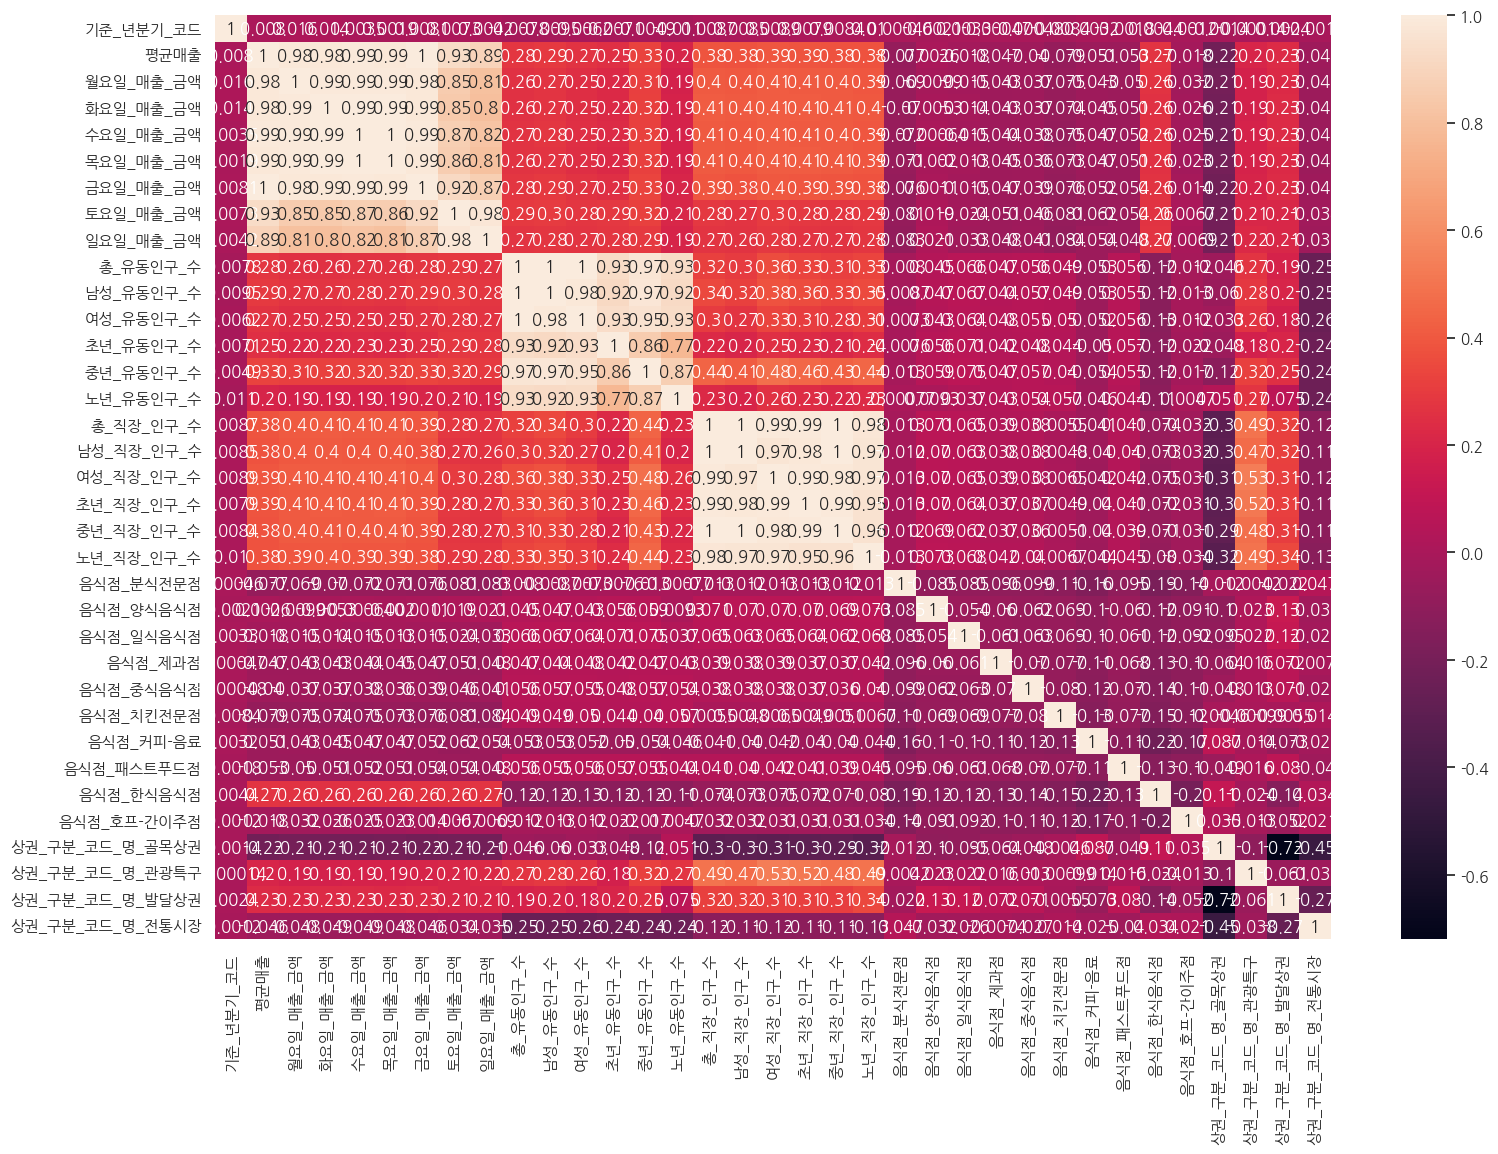

In [33]:
plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [34]:
correlation_matrix = corr_matrix.corr()["평균매출"]
correlation_matrix_sorted = correlation_matrix.sort_values(ascending=False)
correlation_matrix_sorted

평균매출               1.000000
금요일_매출_금액          0.999901
수요일_매출_금액          0.998736
목요일_매출_금액          0.998353
월요일_매출_금액          0.998272
화요일_매출_금액          0.998005
토요일_매출_금액          0.989616
일요일_매출_금액          0.985471
음식점_한식음식점          0.561665
여성_직장_인구_수         0.446915
초년_직장_인구_수         0.443267
총_직장_인구_수          0.441060
중년_직장_인구_수         0.440774
노년_직장_인구_수         0.439377
남성_직장_인구_수         0.437024
상권_구분_코드_명_발달상권    0.435974
상권_구분_코드_명_관광특구    0.313172
중년_유동인구_수          0.302785
남성_유동인구_수          0.246913
총_유동인구_수           0.231813
초년_유동인구_수          0.219868
여성_유동인구_수          0.217339
노년_유동인구_수          0.147935
음식점_양식음식점         -0.012959
음식점_호프-간이주점       -0.040560
음식점_일식음식점         -0.072050
상권_구분_코드_명_전통시장   -0.082576
음식점_커피-음료         -0.106614
음식점_중식음식점         -0.121915
기준_년분기_코드         -0.124074
음식점_제과점           -0.141214
음식점_패스트푸드점        -0.154660
음식점_분식전문점         -0.187531
음식점_치킨전문점         -0.220889
상권_구분_코드_명_골목상권   -0.403478
Name: 평균매출, dtype: f

In [35]:
final_seoul_restaurants_copy.to_csv("../data/seoul_sales_data.csv", index=False)

## 시각화 및 분석

In [50]:
# seoul_sales_data.csv 파일을 읽어서 데이터프레임으로 저장
csv_path = "../data/seoul_sales_data.csv"
df_seoul = pd.read_csv(csv_path)

### 주요 변수 간 상관관계 히트맵

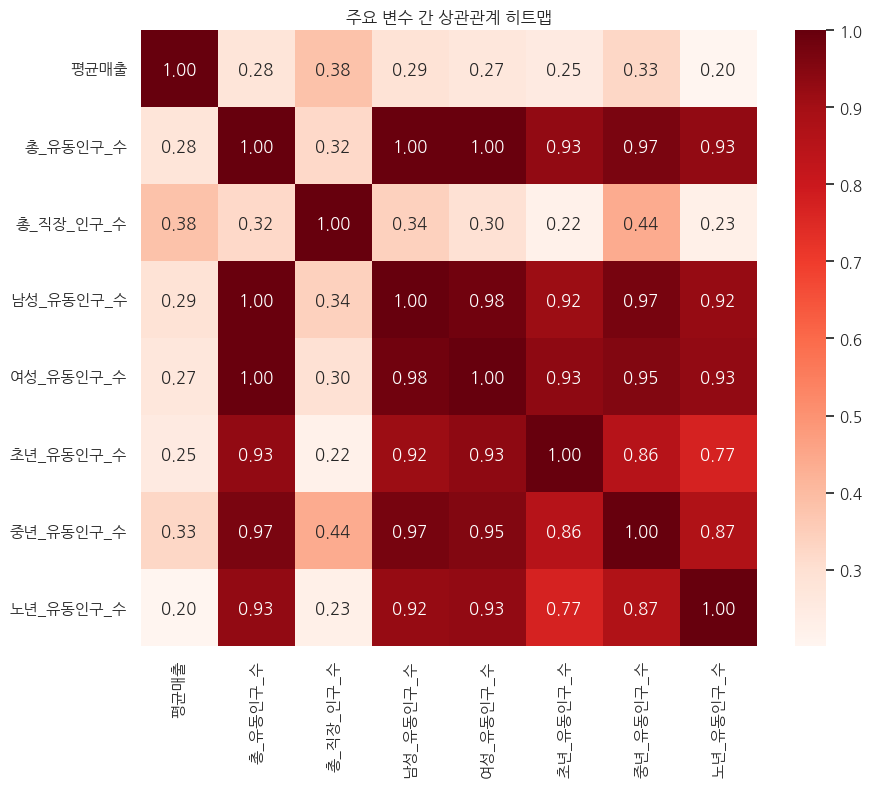

In [109]:
# 평균매출과 유동인구/직장인구/연령대별 인구 간의 상관관계를 분석하고 시각화
# 수치형 변수 중 주요 변수만 추려서
corr = df_seoul[["평균매출", "총_유동인구_수", "총_직장_인구_수", "남성_유동인구_수", "여성_유동인구_수", "초년_유동인구_수", "중년_유동인구_수", "노년_유동인구_수"]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="Reds", fmt=".2f", square=True)
plt.title("주요 변수 간 상관관계 히트맵")
plt.show()

- 분석 목적 : 평균매출과 유동/직장/성별/연령별 인구 변수들 간의 관계를 파악하기 위해
- 분석 결과 : 요일별 매출 금액과의 상관관계가 가장 높으며, 총직장인구, 성별 직장인구와도 중간 정도의 양의 상관관계를 보임

### 평균 매출 기준 시각화

#### 요일별 평균 매출
- **분석 목적:** 어떤 요일에 매출이 높은지를 파악하기 위해.
- **분석 결과:** 금~토요일 매출이 높으며, 주말 매출이 평일보다 더 큼.

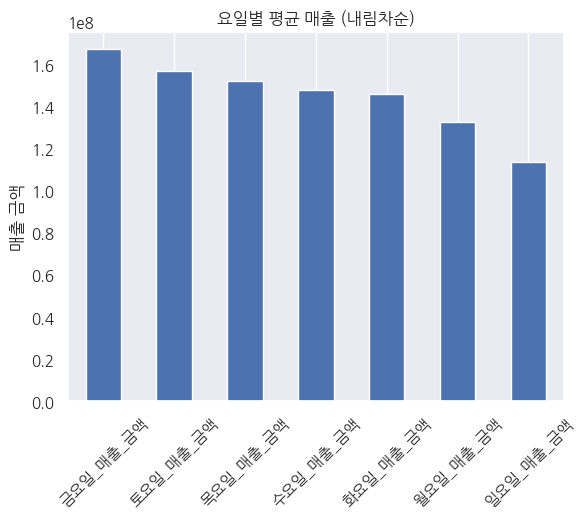

In [59]:
# 각 요일별 매출 평균을 계산한 후, 매출이 높은 순서대로 막대그래프로 시각화
weekday_sales = df_seoul[[
    "월요일_매출_금액", "화요일_매출_금액", "수요일_매출_금액",
    "목요일_매출_금액", "금요일_매출_금액", "토요일_매출_금액", "일요일_매출_금액"
]].mean()

# 내림차순 정렬
weekday_sales_sorted = weekday_sales.sort_values(ascending=False)

weekday_sales_sorted.plot(kind="bar")
plt.title("요일별 평균 매출 (내림차순)")
plt.ylabel("매출 금액")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#### 음식점 유형별 평균 매출
- **분석 목적:** 업종별로 매출이 얼마나 차이 나는지 확인하기 위해.
- **분석 결과:** 한식, 양식, 호프/간이주점 업종의 매출이 상대적으로 높게 나타남.

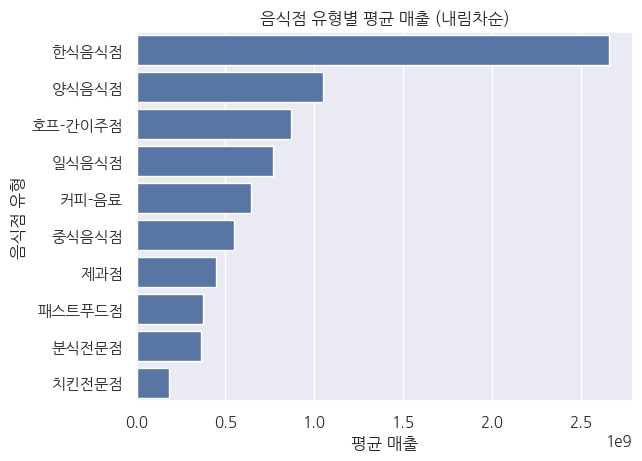

In [58]:
# '음식점_'으로 시작하는 컬럼명을 찾아서 각 업종에 해당하는 평균 매출 계산
음식점_컬럼들 = [col for col in df_seoul.columns if col.startswith("음식점_")]

음식점_매출 = {
    col.replace("음식점_", ""): df_seoul.loc[df_seoul[col] == True, "평균매출"].mean()
    for col in 음식점_컬럼들
}

# 내림차순 정렬
정렬된_음식점 = sorted(음식점_매출.items(), key=lambda x: x[1], reverse=True)

sns.barplot(
    x=[x[1] for x in 정렬된_음식점],
    y=[x[0] for x in 정렬된_음식점]
)
plt.title("음식점 유형별 평균 매출 (내림차순)")
plt.xlabel("평균 매출")
plt.ylabel("음식점 유형")
plt.show()

#### 상권 유형별 평균 매출
- **분석 목적:** 상권의 종류에 따라 매출이 어떻게 달라지는지 확인.
- **분석 결과:** 관광특구, 발달상권의 매출이 높고, 골목상권이 가장 낮음.

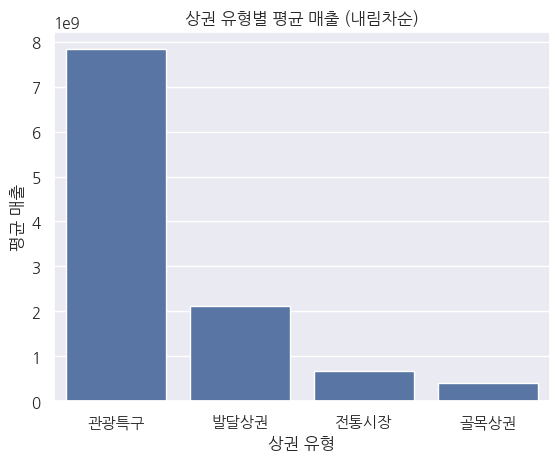

In [60]:
# 상권 구분 코드명에 따른 매출 평균을 계산
상권_컬럼들 = [col for col in df_seoul.columns if col.startswith("상권_구분_코드_명_")]

상권_매출 = {
    col.replace("상권_구분_코드_명_", ""): df_seoul.loc[df_seoul[col] == True, "평균매출"].mean()
    for col in 상권_컬럼들
}

# 내림차순 정렬
정렬된_상권 = sorted(상권_매출.items(), key=lambda x: x[1], reverse=True)

sns.barplot(
    x=[x[0] for x in 정렬된_상권],
    y=[x[1] for x in 정렬된_상권]
)
plt.title("상권 유형별 평균 매출 (내림차순)")
plt.ylabel("평균 매출")
plt.xlabel("상권 유형")
plt.show()

#### 유동인구별 평균 매출
- **분석 목적:** 상권에 유입되는 전체 인구 수가 매출에 미치는 영향 확인.
- **분석 결과:** 약한 양의 상관관계가 존재하지만, 완전히 선형적이지는 않음.

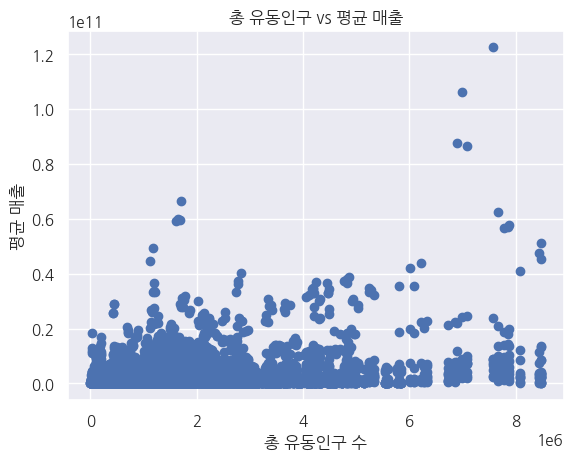

In [67]:
# 총 유동인구 수와 평균 매출 간의 관계를 시각화
plt.scatter(df_seoul["총_유동인구_수"], df_seoul["평균매출"])
plt.title("총 유동인구 vs 평균 매출")
plt.xlabel("총 유동인구 수")
plt.ylabel("평균 매출")
plt.grid(True)
plt.show()

#### 연령대 + 유동인구별 평균 매출
- **분석 목적:** 연령대에 따른 유동인구 수가 매출에 미치는 영향 분석.
- **분석 결과:** 중년층(30대)의 유동인구가 많을수록 매출이 높은 경향이 있음.

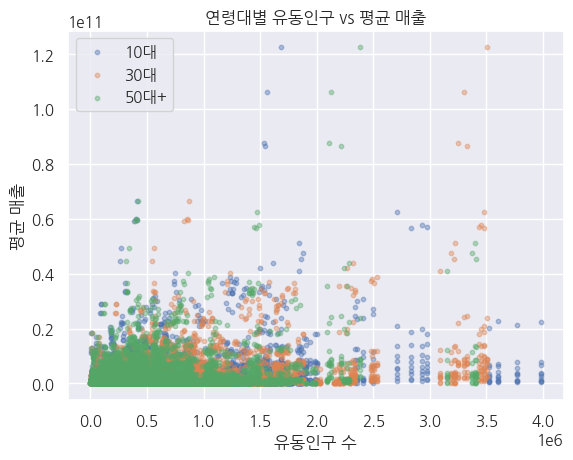

In [92]:
# 연령대별 유동인구(초년, 중년, 노년)와 평균 매출의 관계를 산점도로 시각화
plt.scatter(df_seoul["초년_유동인구_수"], df_seoul["평균매출"], alpha=0.4, label="10대", s=10)
plt.scatter(df_seoul["중년_유동인구_수"], df_seoul["평균매출"], alpha=0.4, label="30대", s=10)
plt.scatter(df_seoul["노년_유동인구_수"], df_seoul["평균매출"], alpha=0.4, label="50대+", s=10)
plt.title("연령대별 유동인구 vs 평균 매출")
plt.xlabel("유동인구 수")
plt.ylabel("평균 매출")
plt.legend()
plt.grid(True)
plt.show()

#### 총 직장인구별 평균 매출 
- **분석 목적:** 직장인 수가 많은 지역이 매출에도 영향을 미치는지 확인.
- **분석 결과:** 유동인구보다 직장인구와 매출 간 상관관계가 조금 더 강하게 나타남.


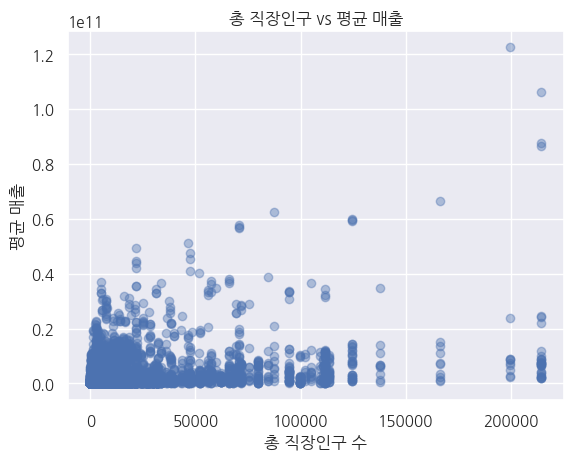

In [91]:
# 총 직장인구 수와 평균 매출 간의 관계를 시각화
plt.scatter(df_seoul["총_직장_인구_수"], df_seoul["평균매출"], alpha=0.4)
plt.title("총 직장인구 vs 평균 매출")
plt.xlabel("총 직장인구 수")
plt.ylabel("평균 매출")
plt.grid(True)
plt.show()

#### 성별 유동인구별 평균 매출
- **분석 목적** : 남성/여성 유동인구 수가 매출에 어떤 영향을 주는지 확인하기 위해
- **분석 결과** : 여성 유동인구가 많은 지역에서 평균 매출이 더 높은 경향을 보임

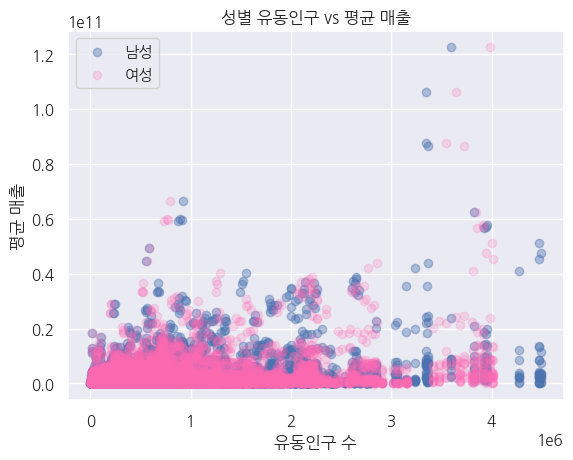

In [105]:
# 남성과 여성 유동인구 수와 평균 매출 간의 관계를 각각 시각화
plt.scatter(df_seoul["남성_유동인구_수"], df_seoul["평균매출"], alpha=0.4, label="남성")
plt.scatter(df_seoul["여성_유동인구_수"], df_seoul["평균매출"], alpha=0.2, color="hotpink", label="여성")
plt.title("성별 유동인구 vs 평균 매출")
plt.xlabel("유동인구 수")
plt.ylabel("평균 매출")
plt.legend()
plt.grid(True)
plt.show()

### 변수 중심 관계 분석

In [80]:
print(df_seoul.columns.tolist())

['기준_년분기_코드', '상권_코드_명', '평균매출', '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액', '총_유동인구_수', '남성_유동인구_수', '여성_유동인구_수', '초년_유동인구_수', '중년_유동인구_수', '노년_유동인구_수', '총_직장_인구_수', '남성_직장_인구_수', '여성_직장_인구_수', '초년_직장_인구_수', '중년_직장_인구_수', '노년_직장_인구_수', '음식점_분식전문점', '음식점_양식음식점', '음식점_일식음식점', '음식점_제과점', '음식점_중식음식점', '음식점_치킨전문점', '음식점_커피-음료', '음식점_패스트푸드점', '음식점_한식음식점', '음식점_호프-간이주점', '상권_구분_코드_명_골목상권', '상권_구분_코드_명_관광특구', '상권_구분_코드_명_발달상권', '상권_구분_코드_명_전통시장']


#### 상권별 매출 분포

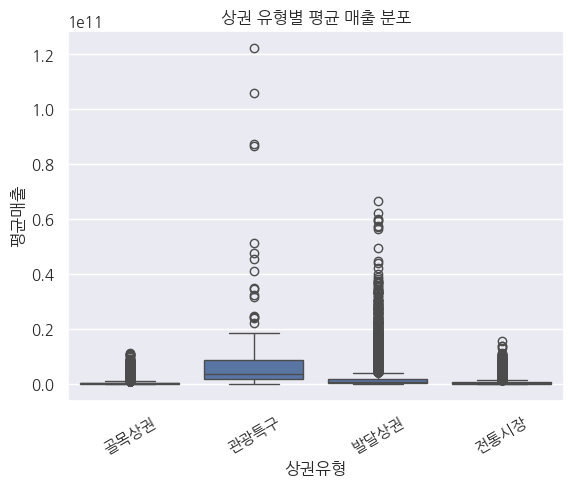

In [77]:
# melt로 긴 형식으로 바꿔주기
temp_df = pd.DataFrame()

for col in [c for c in df_seoul.columns if c.startswith("상권_구분_코드_명_")]:
    상권명 = col.replace("상권_구분_코드_명_", "")
    temp = df_seoul[df_seoul[col] == True].copy()
    temp["상권유형"] = 상권명
    temp_df = pd.concat([temp_df, temp])

sns.boxplot(x="상권유형", y="평균매출", data=temp_df)
plt.title("상권 유형별 평균 매출 분포")
plt.xticks(rotation=30)
plt.show()

#### 연령대별 유동인구 평균값
- **분석 목적:** 연령대에 따른 유동인구 수가 매출에 미치는 영향 분석.
- **분석 결과:** 중년층(30대)의 유동인구가 많을수록 매출이 높은 경향이 있음.

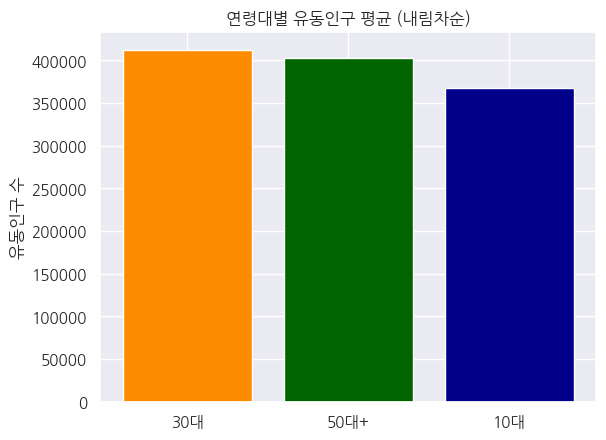

In [101]:
# 연령대별 유동인구 평균값을 구하고, 내림차순으로 막대그래프로 시각화
연령대_유동인구 = {
    "10대": df_seoul["초년_유동인구_수"].mean(),
    "30대": df_seoul["중년_유동인구_수"].mean(),
    "50대+": df_seoul["노년_유동인구_수"].mean()
}

# 내림차순 정렬
정렬된_연령대 = dict(sorted(연령대_유동인구.items(), key=lambda x: x[1], reverse=True))

plt.bar(정렬된_연령대.keys(), 정렬된_연령대.values(), color=["darkorange", "darkgreen", "darkblue"])
plt.title("연령대별 유동인구 평균 (내림차순)")
plt.ylabel("유동인구 수")
plt.show()

#### 성별 유동인구 평균값
- **분석 목적:** 남성/여성 유동인구 수와 매출 간 관계를 확인.
- **분석 결과:** 여성 유동인구가 많은 지역에서 매출이 다소 높은 경향을 보임.

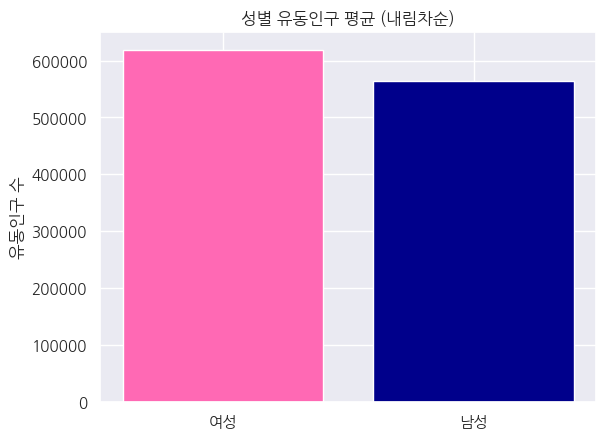

In [106]:
# 남성과 여성의 유동인구 평균값을 비교하고 시각화
성별_유동인구 = {
    "남성": df_seoul["남성_유동인구_수"].mean(),
    "여성": df_seoul["여성_유동인구_수"].mean()
}

정렬된_성별 = dict(sorted(성별_유동인구.items(), key=lambda x: x[1], reverse=True))

plt.bar(정렬된_성별.keys(), 정렬된_성별.values(), color=["hotpink", "darkblue"])
plt.title("성별 유동인구 평균 (내림차순)")
plt.ylabel("유동인구 수")
plt.show()